In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit, prange

In [2]:
DATASET_ID = 'goop'
FILENAME_STRUCTURE = 'prep-data/goop-2104.csv'
FILENAME_CONTENT = 'similarity-graphs/goop-2104-adj.npy'

In [3]:
def remove_protocol(url):
    assert url.startswith('http'), f'Formatting error: URL "{url}" not valid.'
    
    if url.startswith('http://'):
        return url[7:]
    else:
        return url[8:]

## Load data

In [4]:
structure_df = pd.read_csv(FILENAME_STRUCTURE, usecols=['url', 'connected_to'])
structure_df['url'] = structure_df['url']
structure_df.head()

,url,connected_to
0,goop.com/,"goop.com/#main-content,shop.goop.com/shop/coll..."
1,shop.goop.com/shop/collection/accessories,shop.goop.com/shop/collection/accessories#page
2,shop.goop.com/shop/collection/books,shop.goop.com/shop/collection/books#page
3,shop.goop.com/shop/collection/home,shop.goop.com/shop/collection/home#page
4,goop.com/wellness/spirituality/faith-in-the-ti...,goop.com/wellness/spirituality/faith-in-the-ti...


### Create the graph of the structure

### Check if there are duplicates

In [5]:
unique_urls, count_duplicates = np.unique(structure_df['url'].values, return_counts=True)
duplicate_urls = unique_urls[count_duplicates > 1]
assert np.sum(count_duplicates > 1) == 0, 'There sould not be duplicates in data'

### Effectively creating the graph

In [6]:
structure_graph = nx.Graph()
structure_graph.add_nodes_from(structure_df['url'].values)

### Create an adjency matrix

In [7]:
for _, row in structure_df.iterrows():
    from_url = row['url']
    connected_to = row['connected_to']
    
    # Don't consider null values
    if not pd.isnull(connected_to):
        for to_url in connected_to.split(','):
            # Don't consider connections which are not pages themselves
            if to_url in structure_graph:
                structure_graph.add_edge(from_url, to_url)

### Transform it to an adj matrix

In [8]:
structure = nx.to_numpy_matrix(structure_graph, nodelist=structure_df['url'].values, dtype=np.bool)

### Load the content adj matrix

In [9]:
content = np.load(FILENAME_CONTENT)

## Get data sizes

In [10]:
print('Structure len:', structure.shape[0])
print('Content len:', content.shape[0])

Structure len: 26219
Content len: 26219


## Compute phase

### Degree cumulative distribution

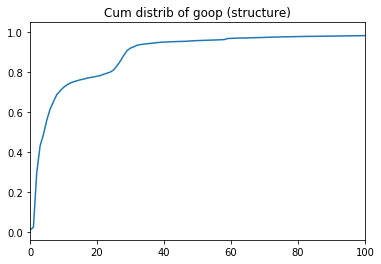

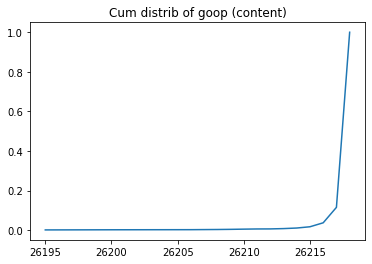

In [24]:
@jit(nopython=True, nogil=True, parallel=True, fastmath=True)
def node_degrees_m(adj, out):
    for row_idx in prange(adj.shape[0]):
        row = adj[row_idx]
        out[row_idx] = np.count_nonzero(row)
        
def degrees_cum_distrib(adj, out):
    node_degrees_m(adj, out)
    
    vals, counts = np.unique(out, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts / np.max(cum_counts)
    return vals, cum_counts

def plot_degrees_cum_distrib(adj, title, xlim=None):
    out = np.zeros(adj.shape[0], dtype=np.int32)
    vals, counts = degrees_cum_distrib(adj, out)
    
    plt.plot(vals, counts)
    
    if xlim is not None:
        plt.xlim(xlim)
        
    plt.title(f'Cum distrib of {DATASET_ID} {title}')
    plt.show()
    
plot_degrees_cum_distrib(structure, '(structure)', xlim=[0, 100])
plot_degrees_cum_distrib(content, '(content)')